# Predicting Titantic Survivorship

### Alex Lau

## Problem

Can we *quickly* predict suvivorship on the Titanic with greater than 75% ROC AUC using 80% of the data for training and 20% for testing?

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, confusion_matrix

%matplotlib inline

## Gathering Data

In [2]:
# Reading in dataframe
df = pd.read_csv('../data/train.csv')

In [3]:
# reviewing the first 5 rows
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Exploratory Data Analysis

In [4]:
# checking size of df
df.shape

(891, 12)

In [5]:
# looking for null values and datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
# getting statistics of the data
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
# gathering null values
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [8]:
# looking at all unique values in tickets
df['Ticket'].value_counts

<bound method IndexOpsMixin.value_counts of 0             A/5 21171
1              PC 17599
2      STON/O2. 3101282
3                113803
4                373450
             ...       
886              211536
887              112053
888          W./C. 6607
889              111369
890              370376
Name: Ticket, Length: 891, dtype: object>

In [9]:
# looking at all unique values in cabins
df['Cabin'].value_counts

<bound method IndexOpsMixin.value_counts of 0       NaN
1       C85
2       NaN
3      C123
4       NaN
       ... 
886     NaN
887     B42
888     NaN
889    C148
890     NaN
Name: Cabin, Length: 891, dtype: object>

In [10]:
# checking the survivor rate among all passengers
df['Survived'].value_counts(normalize = True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

## Cleaning Data

In [11]:
# Creating lists of columns to drop and another list of categories to split
columns_to_drop = ['Cabin', 'Ticket', 'Name', 'PassengerId'] # added passengerID post session
categories = ['Sex', 'Embarked']

In [12]:
# Drop these values because either have too many missing values, or do not help us predict suvivorship
df.drop(columns = columns_to_drop, inplace = True)

# dropping users without age and embarked values populated
df.dropna(inplace = True)

In [13]:
df.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [14]:
# separate columns for all categorical features
df = pd.get_dummies(data = df, columns = categories, drop_first = True)

In [15]:
# checking the dataframe
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


## Preprocessing

In [16]:
# Setting our features and target variable
X = df.drop(columns = 'Survived')
y = df['Survived']

n_samples, n_features = X.shape

# splitting up 80% of our data as train set and remaining 20% of data as test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, stratify = y, random_state = 42)

# scaling the data since we have a wide range of numbers
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

## Modeling

In [17]:
# instantiating the model
lr = LogisticRegression()

# fitting model
lr.fit(X_train_sc, y_train)

# predicting values with training and testing data
y_hat_lr_train = lr.predict(X_train_sc)
y_hat_lr_test = lr.predict(X_test_sc)

### Additions since the session

In [18]:
# evaluate the model on training data
roc_auc_score(y_train, y_hat_lr_train)

0.7835513659099654

In [19]:
# evaluate the model on testing data
roc_auc_score(y_test,
              y_hat_lr_test)

0.7855983772819473

Plotting the curve

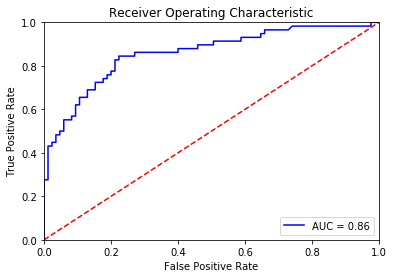

In [20]:
# following code from stack overflow: https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

from sklearn.metrics import roc_curve, auc

# calculate the fpr and tpr for all thresholds of the classification
probs = lr.predict_proba(X_test_sc)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

# plotting
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Conclusion

After training our model with 80% of the data and testing the remaining 20% we were able to achieve a ROC AUC score of 78.56% with our Logistic Regression model, which is greater than our 75% target. 

## More Models

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from tensorflow.keras.metrics import AUC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

### Decision Tree

In [22]:
# instantiating the model
dt = DecisionTreeClassifier()

# fitting model
dt.fit(X_train_sc, y_train)

# predicting values with training and testing data
y_hat_dt_train = dt.predict(X_train_sc)
y_hat_dt_test = dt.predict(X_test_sc)

In [23]:
# evaluate the model on training data
roc_auc_score(y_train, y_hat_dt_train)

0.9869565217391305

In [24]:
# evaluate the model on testing data
roc_auc_score(y_test, y_hat_dt_test)

0.7036511156186612

### Bagging Classifier

In [25]:
# instantiating the model
bc = BaggingClassifier()

# fitting model
bc.fit(X_train_sc, y_train)

# predicting values with training and testing data
y_hat_bc_train = bc.predict(X_train_sc)
y_hat_bc_test = bc.predict(X_test_sc)

In [26]:
# evaluate the model on training data
roc_auc_score(y_train, y_hat_bc_train)

0.9672373989996152

In [27]:
# evaluate the model on testing data
roc_auc_score(y_test, y_hat_bc_test)

0.7362068965517242

### RandomForestClassifier

In [28]:
# instantiating the model
rf = RandomForestClassifier()

# fitting model
rf.fit(X_train_sc, y_train)

# predicting values with training and testing data
y_hat_rf_train = rf.predict(X_train_sc)
y_hat_rf_test = rf.predict(X_test_sc)

In [29]:
# evaluate the model on training data
roc_auc_score(y_train, y_hat_rf_train)

0.9883544953187123

In [30]:
# evaluate the model on testing data
roc_auc_score(y_test, y_hat_rf_test)

0.7793103448275863

### ExtraTreesClassifier

In [31]:
# instantiating the model
et = ExtraTreesClassifier()

# fitting model
et.fit(X_train_sc, y_train)

# predicting values with training and testing data
y_hat_et_train = et.predict(X_train_sc)
y_hat_et_test = et.predict(X_test_sc)

In [32]:
# evaluate the model on training data
roc_auc_score(y_train, y_hat_et_train)

0.9869565217391305

In [33]:
# evaluate the model on testing data
roc_auc_score(y_test, y_hat_et_test)

0.7503042596348884

### GradientBoostingClassifier

In [34]:
# instantiating the model
gb = GradientBoostingClassifier()

# fitting model
gb.fit(X_train_sc, y_train)

# predicting values with training and testing data
y_hat_gb_train = gb.predict(X_train_sc)
y_hat_gb_test = gb.predict(X_test_sc)

In [35]:
# evaluate the model on training data
roc_auc_score(y_train, y_hat_gb_train)

0.9012440682313712

In [36]:
# evaluate the model on testing data
roc_auc_score(y_test, y_hat_gb_test)

0.7855983772819473

### AdaBoost Classifier

In [37]:
# instantiating the model
ab = AdaBoostClassifier()

# fitting model
ab.fit(X_train_sc, y_train)

# predicting values with training and testing data
y_hat_ab_train = ab.predict(X_train_sc)
y_hat_ab_test = ab.predict(X_test_sc)

In [38]:
# evaluate the model on training data
roc_auc_score(y_train, y_hat_ab_train)

0.8302103373092216

In [39]:
# evaluate the model on testing data
roc_auc_score(y_test, y_hat_ab_test)

0.7961460446247464

Adaboost performs well on the test set, but 83% on the training set is the lowest among the classifiers.

### Neural Network with Keras

In [40]:
# instantiate model
model = Sequential()

# add layer
model.add(Dense(units = 100,
               input_shape = (8, ),
               activation = 'relu'))

In [41]:
# add final layer
model.add(Dense(units = 1, activation = 'sigmoid'))

In [42]:
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=[AUC()])

In [43]:
X_train_sc = np.asarray(X_train_sc)
y_train = np.asarray(y_train)
X_test_sc = np.asarray(X_test_sc)
y_test = np.asarray(y_test)

In [44]:
np.random.seed(42)

history = model.fit(x = X_train_sc,
          y = y_train,
          epochs = 30,
          batch_size = 512,
          validation_data = (X_test_sc, y_test),
          verbose = 1)

Train on 569 samples, validate on 143 samples
Epoch 1/30
569/569 [==============================] - 1s 1ms/sample - loss: 0.7435 - auc: 0.2782 - val_loss: 0.7394 - val_auc: 0.3027
Epoch 2/30
569/569 [==============================] - 0s 30us/sample - loss: 0.7249 - auc: 0.3055 - val_loss: 0.7212 - val_auc: 0.3223
Epoch 3/30
569/569 [==============================] - 0s 28us/sample - loss: 0.7076 - auc: 0.3475 - val_loss: 0.7037 - val_auc: 0.3982
Epoch 4/30
569/569 [==============================] - 0s 31us/sample - loss: 0.6912 - auc: 0.4477 - val_loss: 0.6870 - val_auc: 0.5085
Epoch 5/30
569/569 [==============================] - 0s 28us/sample - loss: 0.6758 - auc: 0.5628 - val_loss: 0.6715 - val_auc: 0.6264
Epoch 6/30
569/569 [==============================] - 0s 32us/sample - loss: 0.6609 - auc: 0.6654 - val_loss: 0.6570 - val_auc: 0.6897
Epoch 7/30
569/569 [==============================] - 0s 28us/sample - loss: 0.6474 - auc: 0.7254 - val_loss: 0.6436 - val_auc: 0.7216
Epoch 8/30

It seems this last model is improving quite well with auc of 85.19% after 30 epochs, along with the other parameters we passed.

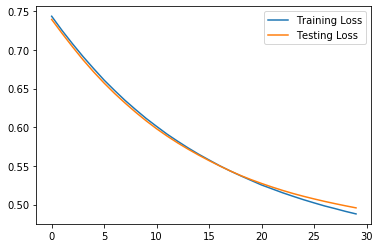

In [45]:
# plotting the model
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Testing Loss')
plt.legend();

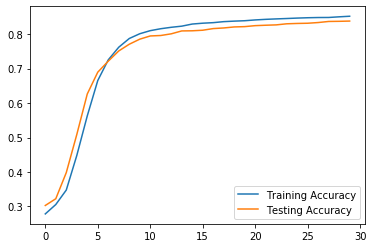

In [46]:
# plotting model's AUC
plt.plot(history.history['auc'], label = 'Training Accuracy')
plt.plot(history.history['val_auc'], label = 'Testing Accuracy')
plt.legend();